In [12]:
import os
os.chdir('/home/gabo/Documents/Facultad-local/Urdimbres-Sofisticadas')
from time import time

In [13]:
from lectura import ldata
import networkx as nx
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd


import sys
sys.path.append('./Tp2/')
from agregar_esencialidad import agregar_esencialidad, agregar_esencialidad_dict

#%%
apms = ldata('Tp2/tc02Data/yeast_AP-MS.txt')

y2h = ldata('Tp2/tc02Data/yeast_Y2H.txt')

lit = ldata('Tp2/tc02Data/yeast_LIT.txt')

lit_r = ldata('Tp2/tc02Data/yeast_LIT_Reguly.txt')
lit_r = [fila[:2] for fila in lit_r[1:]]


g_apms = nx.Graph()
g_apms.add_edges_from(apms)
g_apms = max(nx.connected_component_subgraphs(g_apms), key=len)

g_lit = nx.Graph()
g_lit.add_edges_from(lit)
g_lit = max(nx.connected_component_subgraphs(g_lit), key=len)

g_y2h = nx.Graph()
g_y2h.add_edges_from(y2h)
g_y2h = max(nx.connected_component_subgraphs(g_y2h), key=len)

g_lit_reg = nx.Graph()
g_lit_reg.add_edges_from(lit_r)
g_lit_reg = max(nx.connected_component_subgraphs(g_lit_reg), key=len)

ess = ldata('Tp2/tc02Data/Essential_ORFs_paperHe.txt')
ess =  ess[2:-4]
ess = [fila[1] for fila in ess]
ess = np.unique(ess)

for g in [g_apms, g_lit, g_lit_reg, g_y2h]:
    agregar_esencialidad_dict(g, ess)

def k_medio(g):
    N = g.order()
    k_med = sum(k for (nodo, k) in g.degree) / N
    return k_med

In [30]:
################ Punto B:

######## Tabla 1 de Zotenko: propiedades de las bases de datos

def fila_tabla_1(g):
    g = max(nx.connected_component_subgraphs(g), key=len)
    N = g.order()
    L = g.size()
    K = k_medio(g)
    Ci = np.average(list(nx.clustering(g).values()))
    return N, L, K, Ci

grafos = [g_lit, g_lit_reg, g_apms, g_y2h]
Ns, Ls, Ks, Cis = [], [], [], []
for g in grafos:
    N, L, K, Ci = fila_tabla_1(g)
    Ns.append(N)
    Ls.append(L)
    Ks.append(K)
    Cis.append(Ci)

tabla1 = pd.DataFrame(data={'# Nodos':Ns,
                            '# Enlaces':Ls,
                            'Grado medio':Ks,
                            'Clustering medio':Cis}, 
                      index=['Lit', 'Lit_reg', 'APMS', 'Y2H'])
pd.set_option('precision', 2)
tabla1 

,# Nodos,# Enlaces,Grado medio,Clustering medio
Lit,1213,2621,4.32,0.33
Lit_reg,3224,11789,7.31,0.27
APMS,1004,8319,16.57,0.65
Y2H,1647,2682,3.26,0.06


In [15]:
tabla2 = np.load('Tp2/tc02Data/tabla2zotenko.npz')['data']
tabla2 = pd.DataFrame(data=tabla2, columns=['Lit', 'Lit_reg', 'APMS', 'Y2H'],
                     index=['Lit', 'Lit_reg', 'APMS', 'Y2H'])
tabla2

,Lit,Lit_reg,APMS,Y2H
Lit,1.00,0.98,0.37,0.07
Lit_reg,0.22,1.00,0.17,0.03
APMS,0.12,0.25,1.00,0.01
Y2H,0.07,0.15,0.04,1.00


In [28]:
################ Punto C:


######## Parte II: remoción de nodos no esenciales con grados equivalentes a los esenciales

npzfile = np.load('Tp2/tc02Data/datos_tabla3_100historias_2criterios.npz')
fracs_esen = npzfile['fracs_esen']
fracs_equiv_cv, sigmas_cv, zscores_cv = npzfile['data_cv']
fracs_equiv_cn, sigmas_cn, zscores_cn = npzfile['data_cn']

equiv_prolijo_cv = ['{:.3f} +/- {:.3f}'.format(x, y) for x, y in zip(fracs_equiv_cv, sigmas_cv)]
pd.set_option('precision', 2)
tabla3_cv = pd.DataFrame(data={'Esenciales':fracs_esen,
                            'No esenciales equivalentes':equiv_prolijo_cv,
                            'Z-scores':zscores_cv},
                      index=['Lit', 'Lit_reg', 'APMS', 'Y2H'])
tabla3_cv

,Esenciales,No esenciales equivalentes,Z-scores
Lit,0.28,0.437 +/- 0.008,-20.06
Lit_reg,0.58,0.565 +/- 0.007,1.47
APMS,0.32,0.434 +/- 0.021,-5.15
Y2H,0.62,0.621 +/- 0.011,0.26


In [27]:
equiv_prolijo_cn = ['{:.3f} +/- {:.3f}'.format(x, y) for x, y in zip(fracs_equiv_cn, sigmas_cn)]
pd.set_option('precision', 2)
tabla3_cn = pd.DataFrame(data={'Esenciales':fracs_esen,
                            'No esenciales equivalentes':equiv_prolijo_cn,
                            'Z-scores':zscores_cn},
                      index=['Lit', 'Lit_reg', 'APMS', 'Y2H'])
tabla3_cn

,Esenciales,No esenciales equivalentes,Z-scores
Lit,0.28,0.415 +/- 0.004,-37.67
Lit_reg,0.58,0.539 +/- 0.004,8.44
APMS,0.32,0.396 +/- 0.013,-5.53
Y2H,0.62,0.622 +/- 0.011,0.16


,Pendiente,Ord. al or.,$R^2$adj.,$\alpha$,$\beta$
Lit,-0.064 +/- 0.015,-0.361 +/- 0.094,0.651,0.062 +/- 0.014,0.303 +/- 0.065
Lit_reg,-0.055 +/- 0.006,-0.038 +/- 0.036,0.908,0.054 +/- 0.006,0.037 +/- 0.035
APMS,-0.025 +/- 0.015,-0.214 +/- 0.091,0.172,0.025 +/- 0.014,0.193 +/- 0.074
Y2H,-0.015 +/- 0.011,-0.198 +/- 0.068,0.096,0.015 +/- 0.011,0.180 +/- 0.056


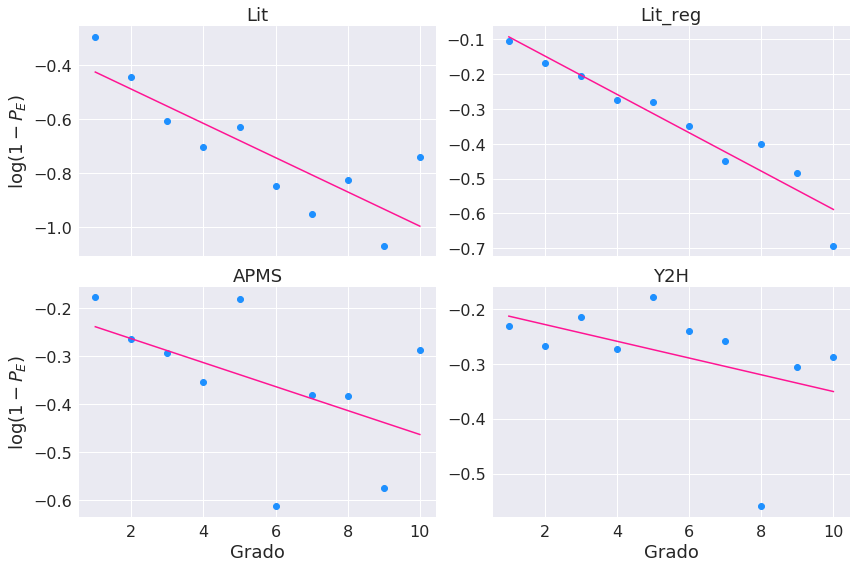

In [16]:
################ Punto D:

######## Tabla ajustes lineales He

def desarme(g, ess):
    nodos, values = agregar_esencialidad(g, ess)
    nodos = []
    k = []
    for a, b in g.degree():
        nodos.append(a)
        k.append(b)
    k_posibles = np.arange(max(k)+1)
    y = []
    x = []
    for j in k_posibles:
        y_i = 0
        x_i = 0 # nro de nodos con grado k
        for i in range(len(nodos)):
            if k[i] == j:
                x_i += 1
                if values[i] == 1:
                    y_i += 1
        if x_i != 0:
            y.append(y_i/x_i)
            x.append(j)
    return x, y

import statsmodels.api as sm
nombres = {g_apms: "APMS", g_lit: "Lit", g_lit_reg: "Lit_reg",
           g_y2h: "Y2H"}

with plt.style.context(('seaborn')):
    fig, ax = plt.subplots(2, 2, figsize=(12,8),
                           sharex=True)
ax = np.ravel(ax)

ms, bs = np.zeros((2, 4)) # 4 grafos, 2 parámetros a ajustar
sigma_ms, sigma_bs = np.zeros((2, 4))
rsquared_adj = np.zeros((4)) # R^2 corregidos

grafos = [g_lit, g_lit_reg, g_apms, g_y2h]
for i, g in enumerate(grafos):
    k_0, y_0 = desarme(g, ess)
    k_1, y_1 = k_0[:10], y_0[:10]
    y_2 = [np.log(1 - yi) for yi in y_1]
    k_2 = sm.add_constant(k_1) # para que haya param ordenada al origen
    results = sm.OLS(y_2, k_2).fit()
    # El orden de los params es 1) ordenada al origen, 2) pendiente
    bs[i] = results.params[0]
    sigma_bs[i] = results.bse[0]
    ms[i] = results.params[1]
    sigma_ms[i] = results.bse[1]
    rsquared_adj[i] = results.rsquared_adj
    
    # Dibujamos
    xs = np.array(k_1)
    ys = y_2
    fontsize = 18
    ticksize = 16
    ax[i].plot(xs, ys, 'o', color='dodgerblue')
    ax[i].plot(xs, ms[i] * xs + bs[i], '-', label='Ajuste lineal',
               color='deeppink')
    ax[i].tick_params(labelsize=ticksize)
    if i in [2, 3]:
        ax[i].set_xlabel('Grado', fontsize=fontsize)
    if i in [0, 2]:
        ax[i].set_ylabel(r'$\log(1-P_E)$', fontsize=fontsize)
    ax[i].set_title(nombres[g], fontsize=fontsize)
    
fig.tight_layout()
#fig.savefig('Tp2/Ej d/figura2b_He.png')

# Obtenemos alfas y betas
alfas = 1 - np.exp(ms)
betas = 1 - np.exp(bs)
# Propagación de errores (chequeé con Monte Carlos que la propagación es correcta)
sigma_alfas = np.exp(ms) * sigma_ms
sigma_betas = np.exp(bs) * sigma_bs

ms_consigmas = ['{:.2f} +/- {:.2f}'.format(x, err) for x, err in zip(ms, sigma_ms)]
bs_consigmas = ['{:.2f} +/- {:.2f}'.format(x, err) for x, err in zip(bs, sigma_bs)]
alfas_consigmas = ['{:.2f} +/- {:.2f}'.format(x, err) for x, err in zip(alfas, sigma_alfas)]
betas_consigmas = ['{:.2f} +/- {:.2f}'.format(x, err) for x, err in zip(betas, sigma_betas)]
rsquared_prolijos = ['{:.2f}'.format(x) for x in rsquared_adj]

ms_consigmas = ['{:.3f} +/- {:.3f}'.format(x, err) for x, err in zip(ms, sigma_ms)]
bs_consigmas = ['{:.3f} +/- {:.3f}'.format(x, err) for x, err in zip(bs, sigma_bs)]
alfas_consigmas = ['{:.3f} +/- {:.3f}'.format(x, err) for x, err in zip(alfas, sigma_alfas)]
betas_consigmas = ['{:.3f} +/- {:.3f}'.format(x, err) for x, err in zip(betas, sigma_betas)]
rsquared_prolijos = ['{:.3f}'.format(x) for x in rsquared_adj]
tabla_ajustes = pd.DataFrame(data = {'Pendiente': ms_consigmas,
                                     'Ord. al or.': bs_consigmas,
                                     r'$R^2$'+'adj.': rsquared_prolijos,
                                     r'$\alpha$': alfas_consigmas,
                                     r'$\beta$': betas_consigmas},
                             index=['Lit', 'Lit_reg', 'APMS', 'Y2H'])
tabla_ajustes

In [18]:
######## Tabla 5 Zotenko

def vecinos_comunes(G, nodo1, nodo2):
    vecinos1 = set(G[nodo1])
    vecinos2 = set(G[nodo2])
    return len(vecinos1.intersection(vecinos2))

def calcular_pares(G, numvecinos, guardar_grados=False):
    num_pares = 0
    num_pares_mismotipo = 0
    if guardar_grados:
        ks_pares = []
    for n1, n2 in nx.non_edges(G):
        if vecinos_comunes(G, n1, n2) >= numvecinos:
            num_pares += 1
            if G.nodes()[n1]['esencialidad'] == G.nodes()[n2]['esencialidad']:
                num_pares_mismotipo += 1
            if guardar_grados:
                k1, k2 = g.degree(n1), g.degree(n2)
                ks_pares.append([k1, k2])
    if guardar_grados:
        return num_pares, num_pares_mismotipo, ks_pares
    else:
        return num_pares, num_pares_mismotipo
#%%
grafos = [g_lit, g_lit_reg, g_apms, g_y2h] # Respetar este orden
pares, pares_mismotipo = np.zeros((2, 4))
grados_pares = []
numvecinos = [1, 3, 3, 1]

ti = time()
for i, g in enumerate(grafos):
    num_pares, num_pares_mismotipo, ks_pares = calcular_pares(g, numvecinos[i],
                                                              guardar_grados=True)
    pares[i] = num_pares
    pares_mismotipo[i] = num_pares_mismotipo
    grados_pares.append(np.array(ks_pares))
tf = time()
print(tf - ti, ' segundos')

def num_pares_esperados(g, ks, alfa, beta):
    """ks debe ser array de forma (n, 2) donde n es el número de pares de nodos
    no vecinos con 'numvecinos' o más vecinos comunes (o más en general, el
    conjunto de pares de nodos que satisface la condición deseada). Debe
    contener los grados de todos los nodos en esos pares.
    
    Devuelve
    --------
    rs : array
        probs de en un dado par, ambos nodos sean esenciales
    ss : array
        probs de en un dado par, ambos nodos sean no esenciales
    num_esperado : float
        el número de pares del mismo tipo esperado según el modelo de He"""
    k1 = ks[:,0]
    k2 = ks[:,1]
    rs = (1 - (1 - beta) * (1 - alfa)**k1) * (1 - (1 - beta) * (1 - alfa)**k2)
    ss = (1 - beta)**2 * (1 - alfa)**(k1 + k2)
    
    num_esperado = np.sum(rs) + np.sum(ss)
    return rs, ss, num_esperado

esperados = []
for i, g in enumerate(grafos):
    _, _, num_esperado = num_pares_esperados(g, grados_pares[i], alfas[i], betas[i])
    esperados.append(num_esperado)

# Para tener incerteza en la estimación de los números esperados
from scipy.stats import norm

incertezas = []
zscores = []
n_historias = 1000
for i, g in enumerate(grafos):
    alfas_mc = norm.rvs(loc=alfas[i], scale=sigma_alfas[i], size=n_historias)
    betas_mc = norm.rvs(loc=betas[i], scale=sigma_betas[i], size=n_historias)
    resultados_mc = np.zeros((n_historias))
    for j in range(n_historias):
        _, _, num_esperado = num_pares_esperados(g, grados_pares[i],
                                                 alfas_mc[j], betas_mc[j])
        resultados_mc[j] = num_esperado
    incertezas.append(np.std(resultados_mc))
    zscores.append((pares_mismotipo[i] - esperados[i]) / incertezas[i])

# Resultados con numvecinos = [3,3,3,3]:
#redes: g_lit, g_lit_reg, g_apms, g_y2h
#pares: 718, 10777, 11569, 522
#pares_mismotipo: 383, 6187, 5875, 352
#esperados: 378, 5791, 6074, 291
#incertezas: 18, 150, 3516, 60
#Z-scores: 0.27, 2.65, -0.06, 1.02

# La red LIT_REG da casi lo mismo que en el paper (en el cual da
# 10777, 6143).

# Resultados con numvecinos = [1,3,3,1]:
#redes: g_lit, g_lit_reg, g_apms, g_y2h
#pares: 9934, 10777, 11569, 23013
#pares_mismotipo: 5767, 6187, 5875, 15045
#esperados: 5008, 5791, 6074, 14204
#incertezas: 100, 144, 2505, 1737
#Z-scores: 7.56, 2.75, -0.08, 0.48

# Resultados con numvecinos = [1,1,1,1]:
#redes: g_lit, g_lit_reg, g_apms, g_y2h
#pares: 9934, 220167, 25915, 23013
#pares_mismotipo: 5767, 127589, 13004, 15045
#esperados: 5008, 118693, 12923, 14204
#incertezas: 83, 3007, 3884, 1822
#Z-scores: 9.16, 2.96, 0.02, 0.46

# En conclusión, se puede rechazar el modelo de He para las redes
# g_lit, g_lit_reg pero no para las redes apms e y2h.

22.56310248374939  segundos


,Número total de pares,# pares del mismo tipo,# esperado de pares del mismo tipo,Z-scores
Lit,9934,5767,5008 +/- 88,8.54
Lit_reg,10777,6187,5790 +/- 147,2.68
APMS,11569,5875,6073 +/- 3048,-0.07
Y2H,23013,15045,14204 +/- 1754,0.48


In [32]:
# Hacemos la tabla prolija linda
pares_prolijo = [int(x) for x in pares]
pares_mismotipo_prolijo = [int(x) for x in pares_mismotipo]
esperados_prolijo = ['{} +/- {}'.format(int(x), int(y)) for x, y in zip(esperados, incertezas)]
zscores_prolijo = ['{:.2f}'.format(x) for x in zscores]

tabla5 = pd.DataFrame(data = {'# Pares': pares_prolijo,
                              '# Pares del mismo tipo': pares_mismotipo_prolijo,
                              '# Pares esperados del mismo tipo': esperados_prolijo,
                              'Z-scores': zscores_prolijo},
                      index=['Lit', 'Lit_reg', 'APMS', 'Y2H'])
tabla5

,# Pares,# Pares del mismo tipo,# Pares esperados del mismo tipo,Z-scores
Lit,9934,5767,5008 +/- 88,8.54
Lit_reg,10777,6187,5790 +/- 147,2.68
APMS,11569,5875,6073 +/- 3048,-0.07
Y2H,23013,15045,14204 +/- 1754,0.48


In [1]:
import pandas as pd
Ns = ['0.062 +/- 0.014', '0.015 +/- 0.011', '0.025 +/- 0.014']
Ls = ['0.059 +/- 0.005', '0.025 +/- 0.004', '0.072 +/- 0.003']
Ks = ['0.303 +/- 0.065', '0.180 +/- 0.056', '-----']
Cis = ['0.277 +/- 0.016', '0.2 +/- 0.01', '-----']
tabla1 = pd.DataFrame(data={r'$\alpha_1$':Ns,
                            r'$\alpha_2$':Ls,
                            r'$\beta_1$':Ks,
                            r'$\beta_2$':Cis}, 
                      index=['LIT', 'Y2H', 'APMS'])
pd.set_option('precision', 2)
tabla1

,$\alpha_1$,$\alpha_2$,$\beta_1$,$\beta_2$
LIT,0.062 +/- 0.014,0.059 +/- 0.005,0.303 +/- 0.065,0.277 +/- 0.016
Y2H,0.015 +/- 0.011,0.025 +/- 0.004,0.180 +/- 0.056,0.2 +/- 0.01
APMS,0.025 +/- 0.014,0.072 +/- 0.003,-----,-----
